In [1]:
!pip install pandas pandas-ta

In [2]:
import pandas as pd
import pandas_ta as ta
import numpy as np

In [31]:
history = pd.read_csv('./AMZN.csv')

In [32]:
# Reverse dataframe to sort prices by date, ascending order
history = history.iloc[::-1]
history = history.reset_index(drop=True)
history = history.iloc[365:730]
history = history.reset_index(drop=True)

In [33]:
history

,Date,Close,Volume,Open,High,Low
0,01/29/2015,15.5890,161348820,15.2365,15.6400,14.9665
1,01/30/2015,17.7265,476934400,17.3160,17.9750,17.0370
2,02/02/2015,18.2235,204444600,17.5025,18.2500,17.5005
3,02/03/2015,18.1775,124180300,18.0145,18.3909,18.0105
4,02/04/2015,18.2375,83348180,17.9190,18.3750,17.9115
...,...,...,...,...,...,...
360,07/05/2016,36.4050,48524080,36.1400,36.4780,35.9805
361,07/06/2016,36.8805,78597800,36.2855,36.8885,36.1290
362,07/07/2016,36.8285,58786080,36.9665,36.9775,36.5815
363,07/08/2016,37.2905,68543940,37.0070,37.3050,36.9000


In [34]:
WINDOW_SIZE = 2

# Initial window/preliminary data
df = history.iloc[0:WINDOW_SIZE]

In [35]:
def compute_indicators(df):
    df = df.copy()

    def get_adx_indicator(name):
        values = ta.adx(df['High'], df['Low'], df['Close'])
        if values is None:
            return -1
        return values.where(np.isfinite, -1)[name]

    df.loc[:, "ADX"] = get_adx_indicator("ADX_14")
    df.loc[:, "+DI"] = get_adx_indicator("DMP_14")
    df.loc[:, "-DI"] = get_adx_indicator("DMN_14")
    
    return df

def update_and_recalculate(df, series_index):
    # Get new update to include in frame
    new_data = history.iloc[series_index].copy()

    # Insert row in frame
    df.loc[len(df)] = new_data

    # Compute TA
    return compute_indicators(df)

In [36]:
df = compute_indicators(df)

In [37]:
df

,Date,Close,Volume,Open,High,Low,ADX,+DI,-DI
0,01/29/2015,15.5890,161348820,15.2365,15.640,14.9665,-1,-1,-1
1,01/30/2015,17.7265,476934400,17.3160,17.975,17.0370,-1,-1,-1


In [38]:
window = df.loc[0:1,['Date','Close', 'ADX', '+DI', '-DI']].to_numpy()
window

array([['01/29/2015', 15.589, -1, -1, -1],
       ['01/30/2015', 17.7265, -1, -1, -1]], dtype=object)

In [39]:
from strategy_adx import AdxBot as Bot
from utils import BotTracker

# Start iterating over the history data. simulates that we gather price data from an external provider
# at every new step/iteration, we add the price data into the dataframe df and recompute TAs
# then we move the window 1 day forward and only pass into the bot that window

start_index = 0

t = BotTracker(start_index + WINDOW_SIZE - 1)
b = Bot(money=5000, events_listener=t)
print(f"Initial money: {b.budget()}")

while start_index < len(history)-WINDOW_SIZE+1:
    df = update_and_recalculate(df, start_index+WINDOW_SIZE-1)
    window = df.loc[start_index:start_index+WINDOW_SIZE-1,['Date','Close', 'ADX', '+DI', '-DI']].to_numpy()
    
    b.think(window)
    if start_index % 100 == 0:
        print(f"Checkpoint at {start_index}, money: {b.budget()}")
    
    start_index += 1
    t.incr()

date, price = df.loc[(len(df)-1), ['Date', 'Close']]
b.finish(date, price)
print(f"Money at the end: {b.budget()}")
    

Initial money: 5000
Checkpoint at 0, money: 5000
Checkpoint at 100, money: 5000
Checkpoint at 200, money: 5000
Checkpoint at 300, money: 3500.0
Closed position, earned: 30%
Closed position, earned: 25%
Money at the end: 5717.395586600434


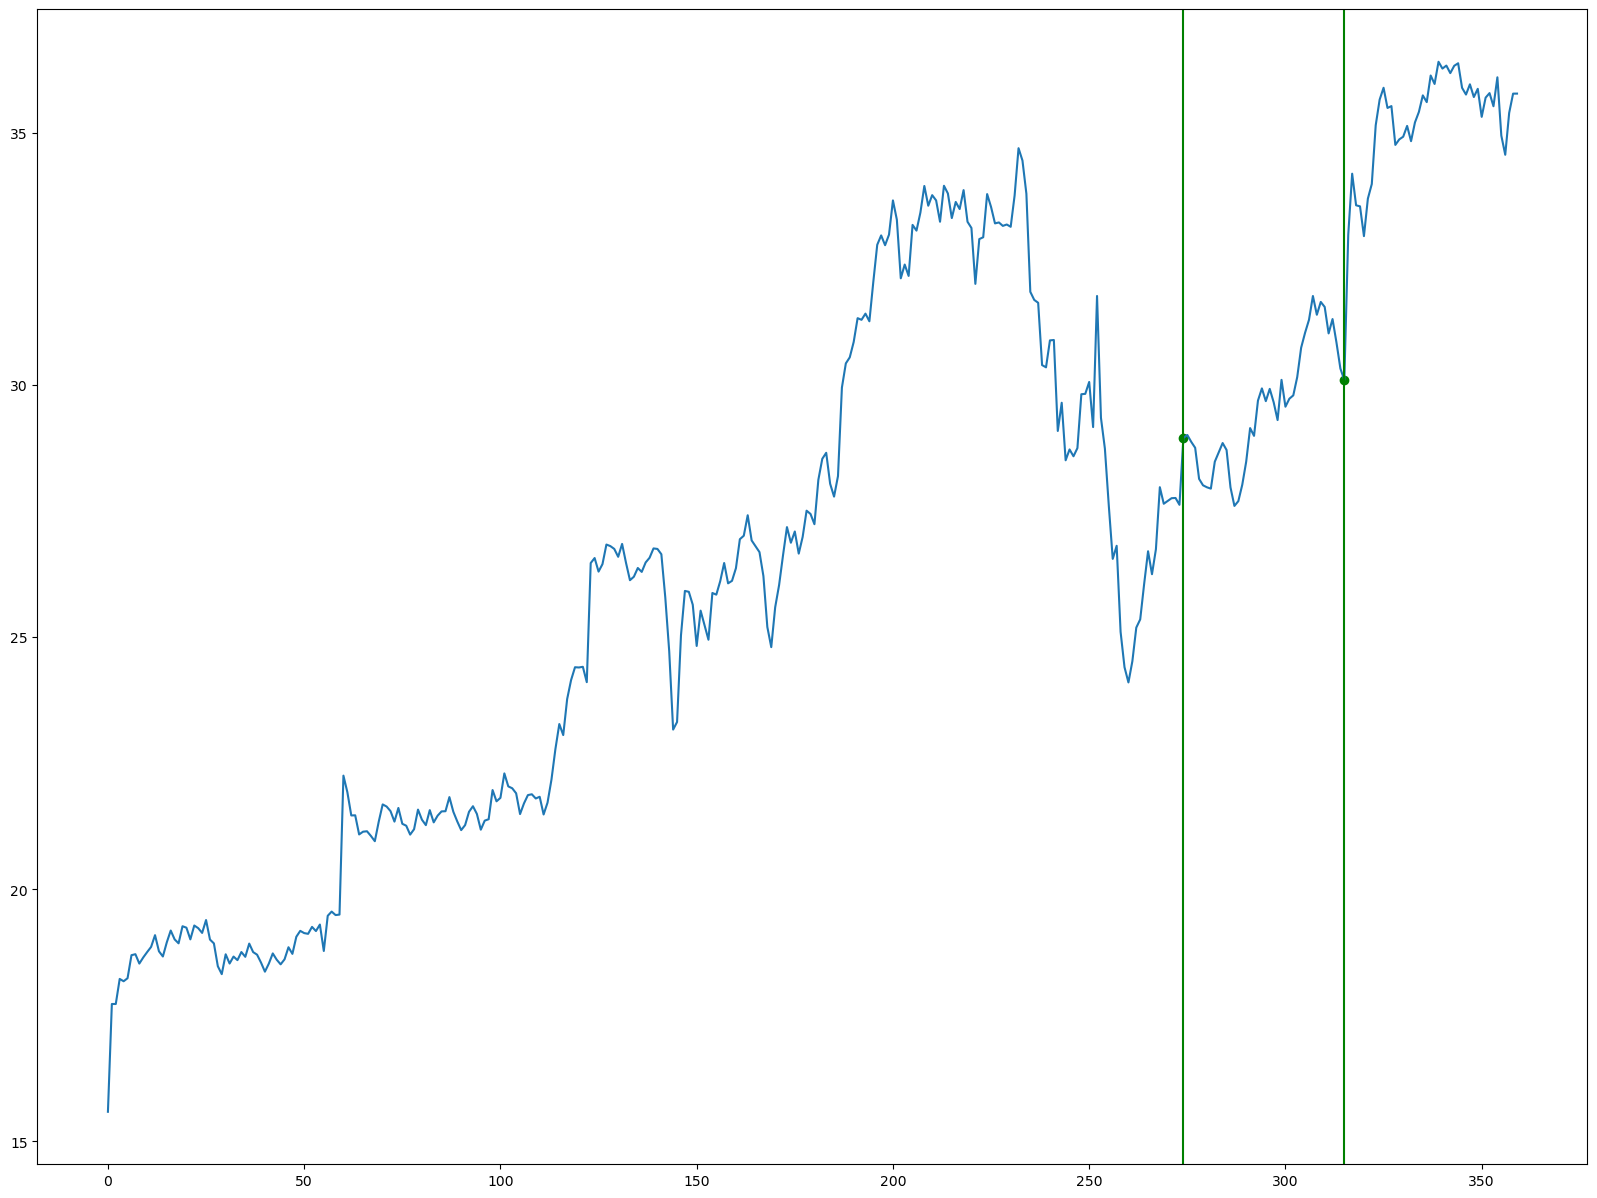

In [44]:
import matplotlib.pyplot as plt

S=0
E=360
#tsignals = ta.adx(df['High'], df['Low'], df['Close']).to_numpy()

prices = df['Close'].to_numpy()
ma20 = df['ADX'].to_numpy()
ma50 = df['-DI'].to_numpy()
ma100 = df['+DI'].to_numpy()

plt.figure(figsize=(20, 15))
plt.plot(prices[S:E])
#plt.plot(ma20[S:E])
#plt.plot(ma50[S:E])
#plt.plot(ma100[S:E])
#plt.plot(tsignals[S:E]-100)

opened_positions_data = t.get_for_rendering()
for p in opened_positions_data:
    if p["index"] < S or p["index"] > E:
        continue
    plt.axvline(x=p["index"]-S, color='green')
    plt.scatter(p["index"]-S, p["price"], color="green")

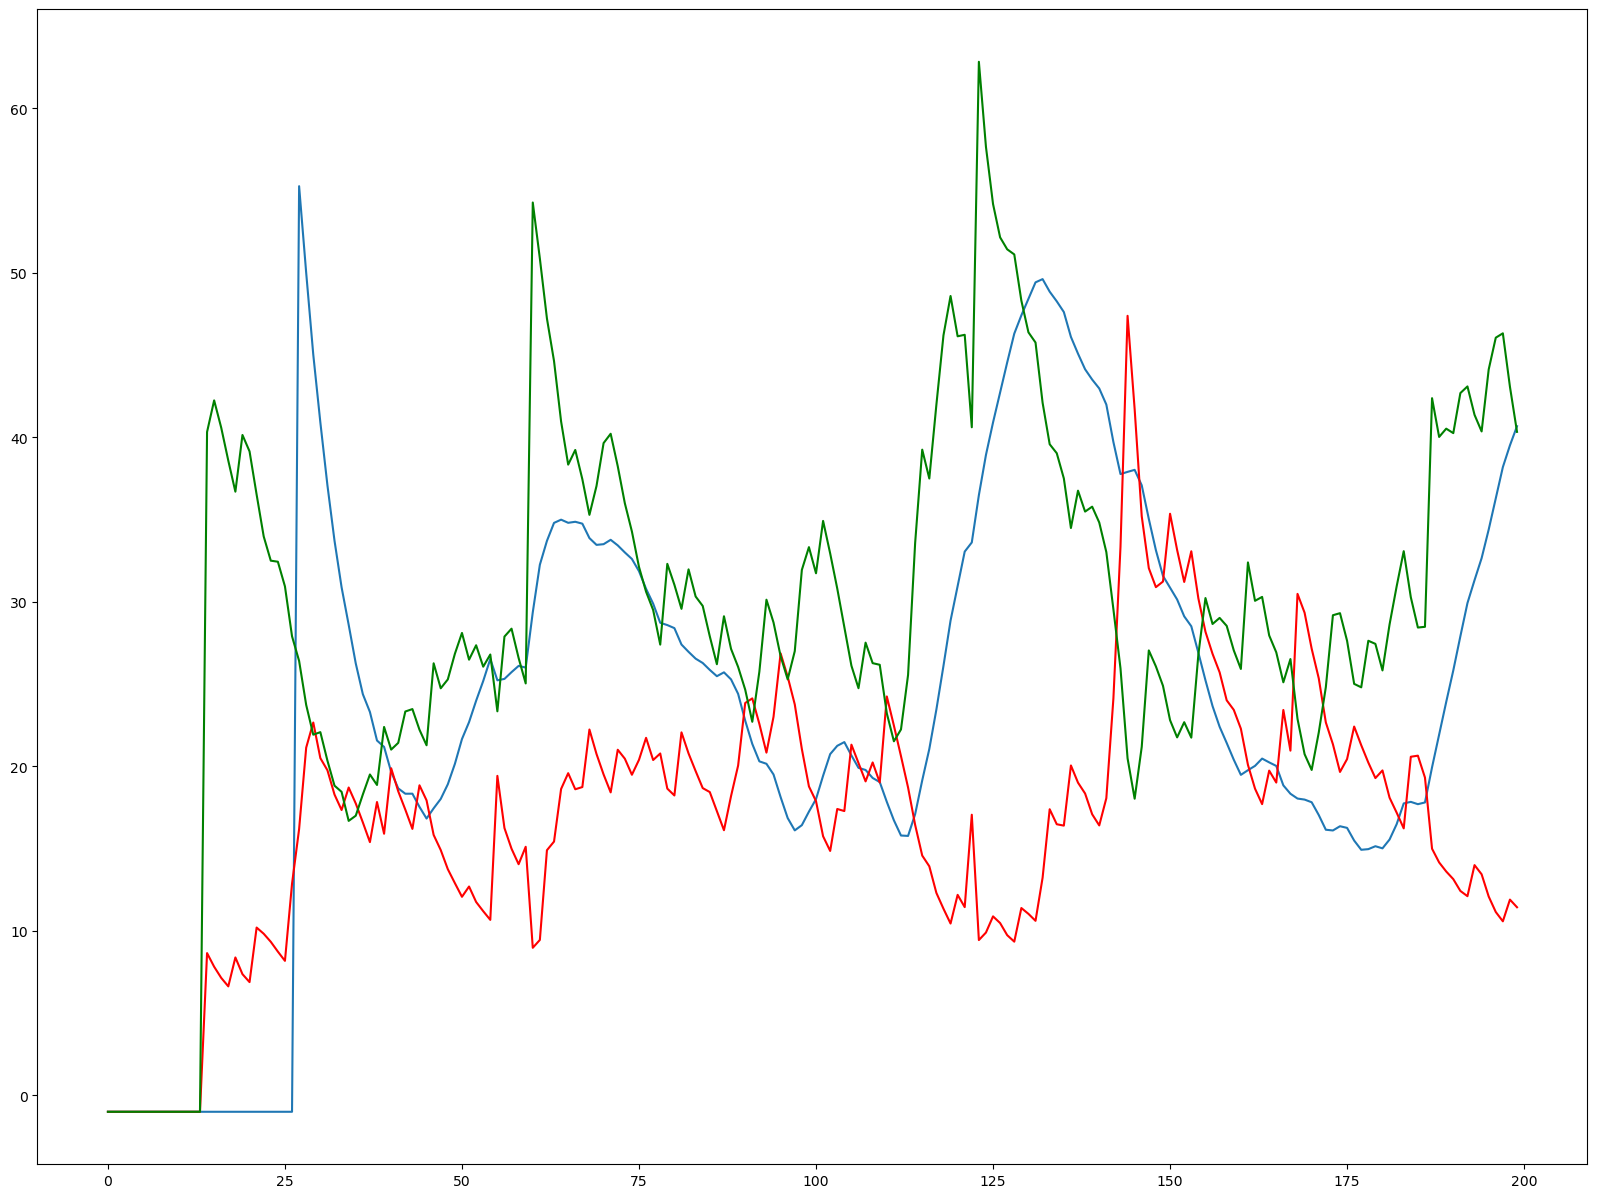

In [43]:
plt.figure(figsize=(20, 15))
plt.plot(ma20[S:E])
plt.plot(ma50[S:E], color='red')
plt.plot(ma100[S:E], color='green')